# A. Plotting Features

### Load the data

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

X_train = pd.read_feather('./X_train_1.feather')
y_train = pd.read_feather('./y_train.feather')['prices.amountMax']

X_val = pd.read_feather('./X_val_1.feather')
y_val = pd.read_feather('./y_val.feather')['prices.amountMax']

rfr = RandomForestRegressor(n_estimators=40, max_features='log2')
rfr.fit(X_train, y_train)
rfr.score(X_val, y_val)

0.4498070416462593

Now let's explore our top features.

In [2]:
import eli5
from eli5.sklearn import PermutationImportance
pmi_limited = PermutationImportance(rfr).fit(X_val, y_val)

In [3]:
eli5.explain_weights_df(pmi_limited, feature_names = X_val.columns.to_list())

,feature,weight,std
0,prices.isSale,0.295789,0.015398
1,brand_Dansko,0.179065,0.010491
2,brand_other,0.083605,0.012454
3,categories_Boots,0.056440,0.010538
4,categories_Slippers,0.052308,0.003961
5,brand_Ugg,0.050982,0.007079
6,manufacturerNumber_other,0.033372,0.005974
7,manufacturer_Nike,0.030141,0.010213
8,categories_Athletic,0.023526,0.009495
9,colors_Green,0.010811,0.004049


### Model Interpretation

Now that we have identified our top features, we still would like to determine how our target variable changes as one of our feature changes.  We can view this simply by plotting our target against changes in our feature.

Because we are not assuming the relationship to be linear, let's use `plotnine` which allows us to plot non-linear relationships.

In [4]:
df_train = X_train.merge(y_train, on = y_train.index).drop(columns = ['key_0'])

In [5]:
from plotnine import *
sampled_train = df_train.sample(n=3000, random_state=1)

C:\Users\51759\Anaconda3\lib\site-packages\plotnine\scales\scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
C:\Users\51759\Anaconda3\lib\site-packages\plotnine\scales\scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
C:\Users\51759\Anaconda3\lib\site-packages\plotnine\stats\smoothers.py:238: UserWarning: See sklearn.gaussian_process.GaussianProcessRegressor for parameters to pass in as 'method_args'
  "See sklearn.gaussian_process.GaussianProcessRegressor "
C:\Users\51759\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances small

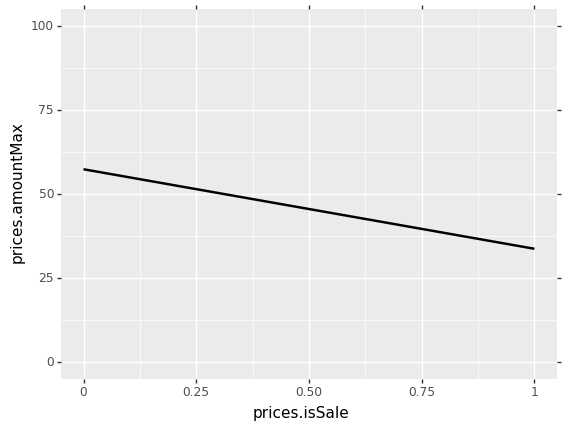

<ggplot: (-9223371901699811910)>

In [6]:
(ggplot(sampled_train, aes('prices.isSale', 'prices.amountMax'))
 + stat_smooth(se=True, method='gpr') + xlim(0, 1) + ylim(0, 100))

* So above we see how price changes along with changes in our prices.isSale value. We can see when the shoe is sold, it has an lower average price.

C:\Users\51759\Anaconda3\lib\site-packages\plotnine\scales\scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
C:\Users\51759\Anaconda3\lib\site-packages\plotnine\scales\scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
C:\Users\51759\Anaconda3\lib\site-packages\plotnine\stats\smoothers.py:238: UserWarning: See sklearn.gaussian_process.GaussianProcessRegressor for parameters to pass in as 'method_args'
  "See sklearn.gaussian_process.GaussianProcessRegressor "
C:\Users\51759\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances small

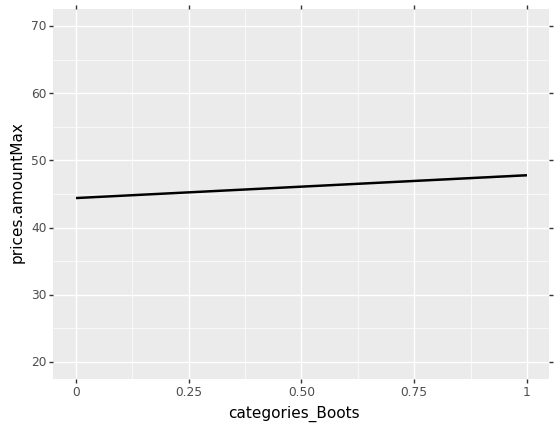

<ggplot: (-9223371901699812001)>

In [7]:
(ggplot(sampled_train, aes('categories_Boots', 'prices.amountMax'))
 + stat_smooth(se=True, method='gpr') + xlim(0, 1) + ylim(20, 70))

* If the shoe types boots, it's probably with a higher price.

Cause all the features are boolean type, not numerical. So the features are not suitable for plotting the price varience along the X axis.

### Seeing independent changes

So ideally, we would be able to see how our target variable changes with a change to our feature variable, holding everything else constant.  It turns out, there that allows us to simulate just that.

Let's see this by way of example.  Assume that we wanted to see what we expect the price would be if number of beds is one. 

In [8]:
X_val.head()

,prices.isSale,brand_Dansko,brand_Ugg,brand_other,manufacturer_Nike,manufacturerNumber_other,categories_Athletic,categories_Boots,categories_Slippers,colors_Green
0,1,0,0,1,0,1,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0
2,0,0,0,1,0,1,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0


Well one way to do this is to take the isSale feature, fill in our feature variables for isSale to always be 0 and then make predictions for each of our observations and take the average. Then to see how much isSale changes as we move from 0 to 1.  
In this way, we are seeing how much our model is rewarding an movement in isSale.  And all of our other data is staying constant, we are simply artificially changing the value of the feature in question.

Plotting this is called a partial dependence plot, and we can use the `pdpbox` library to plot this.

In [9]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators=40, max_features='log2')
rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='log2', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=40,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [10]:
from pdpbox.pdp import pdp_plot, pdp_isolate
import pdpbox
def plot_pdp(model, X, feature_names, feature, clusters = None):
    iso = pdp_isolate(rfr, X_train, X_train.columns, feature)
    return pdp_plot(iso, feature, plot_lines = True, cluster=clusters, n_cluster_centers=clusters)

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1f7003de5f8>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1f70047fb00>})

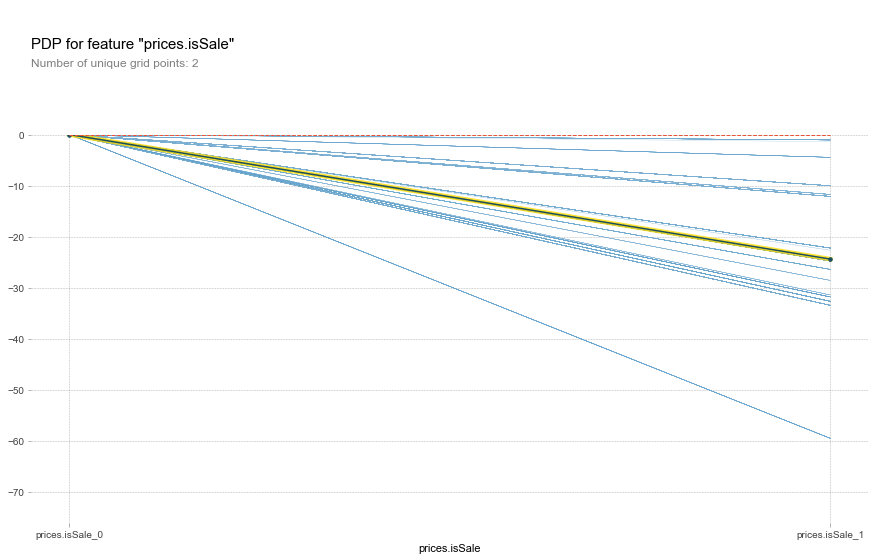

In [11]:
plot_pdp(rfr, X_train.sample(1000), X_train.columns, 'prices.isSale', None)

What we see above is the average value of the target feature in the yellow line, and then each light blue line displays the predicted value of the target for every observation.

If we would like to simplify the data, we can cluster the paths above.  In the next plot, we'll group our paths into 15 clusters.

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1f703e1d208>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1f704053358>})

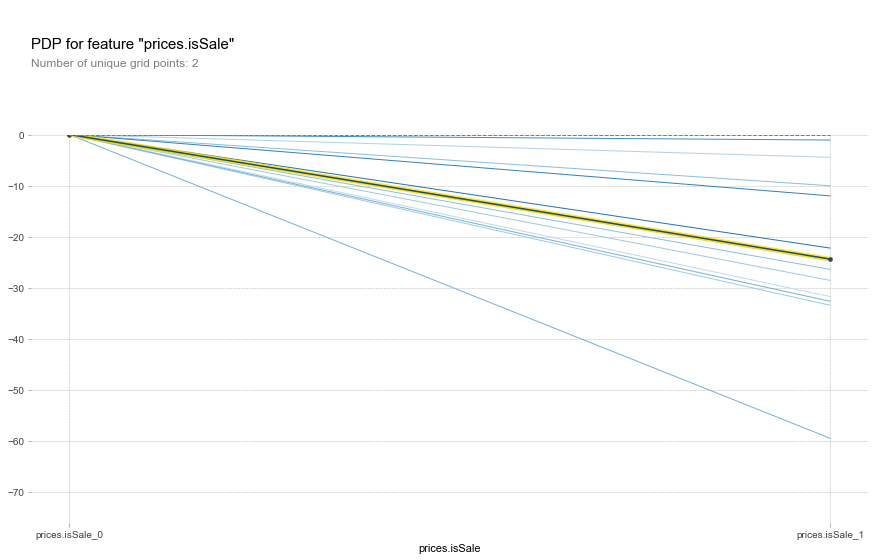

In [12]:
plot_pdp(rfr, X_train.sample(1000), X_train.columns, 'prices.isSale', 15)

We can see that on average, the price decreases by about 20 for isSale from 0 to 1.

# B. Quantifying the impact

In [13]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators=40, max_features='log2', random_state=0)
rfr.fit(X_train, y_train).score(X_val, y_val)

0.449271569928282

### Working with a single tree

In [14]:
first_tree = rfr.estimators_[0]

In [15]:
from sklearn import tree
from IPython.display import SVG, display
from graphviz import Source 


def plot_tree(dt, feature_names, max_depth):
    return Source(tree.export_graphviz(dt, out_file=None,
                                feature_names=feature_names, max_depth=max_depth))

In [16]:
import os
os.environ["PATH"] += os.pathsep + 'c:/Program Files (x86)/Graphviz2.38/bin/'

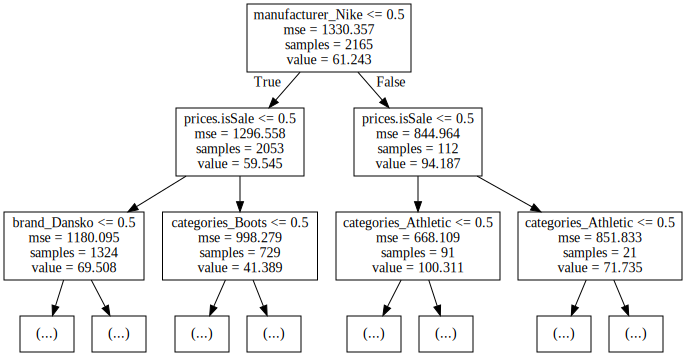

In [17]:
plot_tree(first_tree, X_train.columns, 2)

Well let's take a feature that would fall in the far left hand side of the tree. Well this would be a feature that has zeros for the manufacturer_Nike and prices.isSale.
We can see that the predicted value of the observation goes from  61.24  to  59.54  to  69.50 .

In [18]:
first_obs = X_train.loc[0]

In [19]:
first_obs

prices.isSale               0
brand_Dansko                0
brand_Ugg                   0
brand_other                 1
manufacturer_Nike           0
manufacturerNumber_other    1
categories_Athletic         0
categories_Boots            0
categories_Slippers         0
colors_Green                0
Name: 0, dtype: int32

In [21]:
import eli5
explained_df_first_obs = eli5.explain_prediction_df(first_tree, first_obs)

selected = explained_df_first_obs.feature.isin(['prices.isSale', '<BIAS>', 'manufacturer_Nike'])
explained_df_first_obs[selected]

,target,feature,weight,value
0,y,<BIAS>,61.243115,1.0
1,y,prices.isSale,9.962292,0.0
8,y,manufacturer_Nike,-1.697747,0.0


$$y = \underset{\text{bias}}{61.24}-\underset{\text{manufacturer_Nike=0}}{1.69}+\underset{\text{prices.isSale=0}}{9.96}$$

### Multiple Trees

In [22]:
prediction_expls = []
for idx, row in X_val.iterrows():
    prediction_expls.append(eli5.explain_prediction_df(rfr, row))

In [23]:
train_expl_df = pd.concat(prediction_expls, keys=X_train.index, 
                         names=['observation'])

In [24]:
train_expl_df.value = train_expl_df.value.astype('float64')

In [25]:
train_expl_df.iloc[:5]

target                   feature     weight  value
observation                                                     
0           0      y                    <BIAS>  60.225011    1.0
            1      y       categories_Slippers   0.021916    0.0
            2      y  manufacturerNumber_other  -0.145188    1.0
            3      y              colors_Green  -0.187818    0.0
            4      y         manufacturer_Nike  -0.593656    0.0

In [26]:
train_unstacked_df = (train_expl_df.groupby(['observation','feature'])
                               .weight
                               .aggregate('first')
                               .unstack())
train_unstacked_df.head()

feature,<BIAS>,brand_Dansko,brand_Ugg,brand_other,categories_Athletic,categories_Boots,categories_Slippers,colors_Green,manufacturerNumber_other,manufacturer_Nike,prices.isSale
observation,,,,,,,,,,,
0,60.225011,-0.766384,-0.696109,-5.696454,-0.730767,-1.236298,0.021916,-0.187818,-0.145188,-0.593656,-18.776502
1,60.225011,-3.498034,-1.107352,4.223169,-2.619031,0.313321,1.563740,-0.111278,2.798284,-2.155258,9.444263
2,60.225011,-1.687035,-0.517235,-3.798503,-0.633128,-1.080214,1.717902,-0.512301,0.281079,-1.065259,12.072964
3,60.225011,-3.498034,-1.107352,4.223169,-2.619031,0.313321,1.563740,-0.111278,2.798284,-2.155258,9.444263
4,60.225011,-3.498034,-1.107352,4.223169,-2.619031,0.313321,1.563740,-0.111278,2.798284,-2.155258,9.444263


In [27]:
train_unstacked_df.describe()[train_unstacked_df.describe().index.isin(['mean', 'std'])]

feature,<BIAS>,brand_Dansko,brand_Ugg,brand_other,categories_Athletic,categories_Boots,categories_Slippers,colors_Green,manufacturerNumber_other,manufacturer_Nike,prices.isSale
mean,6.022501e+01,0.167088,-0.397972,0.090584,-0.226172,0.259483,-0.112532,-0.019535,0.118826,-0.368467,0.003189
std,3.412597e-13,12.010477,7.165236,5.501830,3.667154,4.501079,5.848389,1.774690,2.666409,5.443699,13.055235


#### Plotting

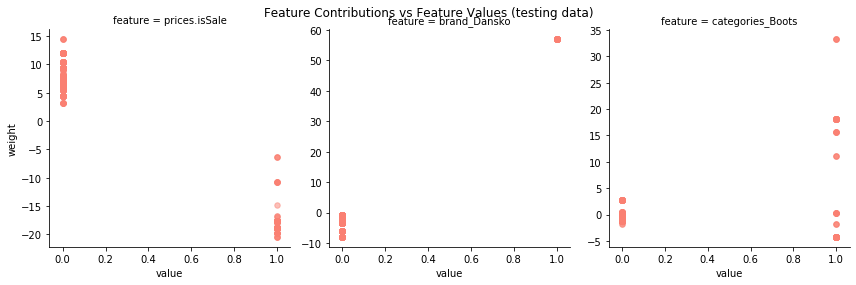

In [28]:
import seaborn as sns
fg = sns.lmplot(x='value', y='weight', col='feature',
                data=train_expl_df.loc[train_expl_df.feature.isin(['prices.isSale', 'brand_Dansko', 'categories_Boots'])], 
                col_order=['prices.isSale', 'brand_Dansko', 'categories_Boots'], sharex=False, sharey=False, col_wrap=3, fit_reg=False, 
                height=4, scatter_kws={'color':'salmon', 'alpha': 0.5, 's':30})


fg.fig.suptitle('Feature Contributions vs Feature Values (testing data)')
fg.fig.subplots_adjust(top=0.90);

* In isSale feature, it's very clear that the data under 1 have a much lower weight on the price.
* In brand_Dansko feature, if the shoe is Dansko its price will be around 60 weight higher than shoes of other brands.
* In categories_Boots feature, the data of other than boots locate closely. On the other side, prices of boots vary hugly and place sparsely.